In [ ]:
import zipfile

with zipfile.ZipFile('/content/drive/MyDrive/faster_rcnn_dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/sample_data')

In [ ]:
import torch

# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [ ]:
from torchvision.models.detection import (
    fasterrcnn_mobilenet_v3_large_fpn,
    FasterRCNN_MobileNet_V3_Large_FPN_Weights,
)

In [ ]:
NUM_CLASSES = 2  # background=0 included, Suzanne = 1

def get_faster_rcnn_model(num_classes):
    """return model and preprocessing transform"""
    model = fasterrcnn_mobilenet_v3_large_fpn(
        weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT
    )
    model.roi_heads.box_predictor.cls_score = torch.nn.Linear(
        in_features=model.roi_heads.box_predictor.cls_score.in_features,
        out_features=num_classes,
        bias=True,
    )
    model.roi_heads.box_predictor.bbox_pred = torch.nn.Linear(
        in_features=model.roi_heads.box_predictor.bbox_pred.in_features,
        out_features=num_classes * 4,
        bias=True,
    )
    preprocess = FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT.transforms()
    return model, preprocess


model, preprocess = get_faster_rcnn_model(num_classes=NUM_CLASSES)
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block):

In [ ]:
print(model.transform)

GeneralizedRCNNTransform(
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    Resize(min_size=(800,), max_size=1333, mode='bilinear')
)


In [ ]:
import json
from collections import defaultdict
from pathlib import Path
from PIL import Image
from torch.utils.data import Dataset


class CocoDataset(Dataset):
    """PyTorch dataset for COCO annotations."""

    # adapted from https://github.com/pytorch/vision/issues/2720

    def __init__(self, root, annFile, transform=None):
        """Load COCO annotation data."""
        self.data_dir = Path(root)
        self.transform = transform

        # load the COCO annotations json
        anno_file_path = annFile
        with open(str(anno_file_path)) as file_obj:
            self.coco_data = json.load(file_obj)
        # put all of the annos into a dict where keys are image IDs to speed up retrieval
        self.image_id_to_annos = defaultdict(list)
        for anno in self.coco_data["annotations"]:
            image_id = anno["image_id"]
            self.image_id_to_annos[image_id] += [anno]

    def __len__(self):
        return len(self.coco_data["images"])

    def __getitem__(self, index):
        """Return tuple of image and labels as torch tensors."""
        image_data = self.coco_data["images"][index]
        image_id = image_data["id"]
        image_path = self.data_dir / image_data["file_name"]
        image = Image.open(image_path)

        annos = self.image_id_to_annos[image_id]
        anno_data = {
            "boxes": [],
            "labels": [],
            "area": [],
            "iscrowd": [],
        }
        for anno in annos:
            coco_bbox = anno["bbox"]
            x = coco_bbox[0]
            y = coco_bbox[1]
            x1 = x - coco_bbox[2]/2
            y1 = y - coco_bbox[3]/2
            x2 = x + coco_bbox[2]/2
            y2 = y + coco_bbox[3]/2
            area = coco_bbox[2] * coco_bbox[3]
            anno_data["boxes"].append([x1, y1, x2, y2])
            anno_data["labels"].append(anno["category_id"])
            anno_data["area"].append(area)

        target = {
            "boxes": torch.as_tensor(anno_data["boxes"], dtype=torch.float32),
            "labels": torch.as_tensor(anno_data["labels"], dtype=torch.int64),
            "image_id": torch.tensor([image_id]),
            "area": torch.as_tensor(anno_data["area"], dtype=torch.float32),
        }

        if self.transform is not None:
            image = self.transform(image)

        return image, target

In [ ]:
import random
import torchvision.transforms as T
from IPython.display import display
from PIL import ImageDraw

# create datasets
training_dataset = CocoDataset(
    root="/content/sample_data/faster_rcnn_dataset/train/images",
    annFile="/content/sample_data/faster_rcnn_dataset/annotations_train.json",
    transform=preprocess,
)
validation_dataset = CocoDataset(
    root="/content/sample_data/faster_rcnn_dataset/val/images",
    annFile="/content/sample_data/faster_rcnn_dataset/annotations_val.json",
    transform=preprocess,
)

random training label: {'boxes': tensor([[637., 464., 697., 524.]]), 'labels': tensor([1]), 'image_id': tensor([601]), 'area': tensor([3600.])}


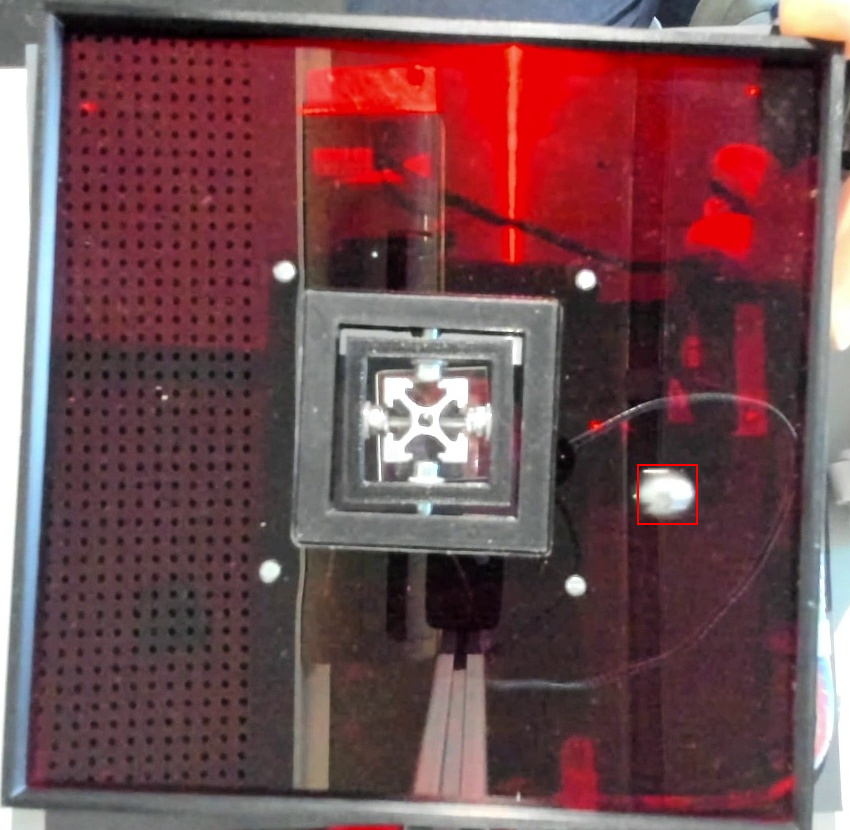

In [ ]:
# get a random training sample
img, label = training_dataset[random.randint(0, len(training_dataset) - 1)]
print(f"random training label: {label}")

# display image with bbox label
transform = T.ToPILImage()
img = transform(img)
x1, y1, x2, y2 = label["boxes"].numpy()[0]
draw = ImageDraw.Draw(img)
draw.rectangle([x1, y1, x2, y2], fill=None, outline="#ff0000cc", width=2)
display(img)

In [ ]:
BATCH_SIZE = 32

def collate(batch):
    """return tuple data"""
    return tuple(zip(*batch))

train_loader = torch.utils.data.DataLoader(
    training_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=12,
    collate_fn=collate,
)

validation_loader = torch.utils.data.DataLoader(
    validation_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=12,
    collate_fn=collate,
)

In [ ]:
X, y = next(iter(validation_loader)) # get a validation batch

model.eval() # set the model in evaluation mode
with torch.no_grad(): # do not compute gradients
    X = [x.to(device) for x in X] # move images to device
    out = model(X) # model forward pass
    print(out)

[{'boxes': tensor([[429.0171, 556.3222, 483.2505, 609.1482],
        [435.4435, 673.5917, 474.0984, 782.3517],
        [523.4626, 284.8871, 592.6278, 451.8904],
        [269.7531, 280.5930, 559.3354, 454.2958],
        [796.9763,   5.0225, 847.4105,  47.9916],
        [342.0299, 283.6577, 554.8364, 695.0229],
        [820.3543, 157.6465, 843.8436, 357.6704],
        [415.8424, 638.5297, 481.3379, 811.0578],
        [818.1727,  50.5456, 845.2120, 169.7398],
        [817.9628, 307.9880, 847.2009, 486.3419],
        [271.4155, 686.1414, 303.7070, 776.7785],
        [263.1952, 366.0151, 793.8672, 517.0466],
        [595.2607,  19.0882, 823.3197, 260.5906],
        [275.7647, 258.6615, 299.2770, 278.4572],
        [413.0816, 673.4742, 452.8987, 780.0118],
        [818.1904, 396.0350, 846.0316, 527.7841],
        [463.1470,  92.5710, 583.6124, 292.2704],
        [  0.0000,  54.0147, 273.5848, 670.9587],
        [ 68.2020, 728.6218, 676.9672, 819.8088],
        [311.0610, 243.4186, 402.2273, 

In [ ]:
params = [p for p in model.parameters() if p.requires_grad]

In [ ]:
optimizer = torch.optim.SGD(
    params,
    lr=0.00001,
    momentum=0.9,
    weight_decay=0.0001
)

In [ ]:
num_epochs = 20
train_loss_list = []
validation_loss_list = []
model.train() # set model in training mode
for epoch in range(num_epochs):
    N = len(train_loader.dataset)
    current_train_loss = 0
    # train loop
    for images, targets in train_loader:
        # move data to device and build the right input format for our model
        images = list(image.to(device) for image in images)
        targets = [
            {
                k: v.to(device) if isinstance(v, torch.Tensor) else v
                for k, v in t.items()
            }
            for t in targets
        ]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        current_train_loss += losses
    train_loss_list.append(current_train_loss / N)

    # validation loop
    N = len(validation_loader.dataset)
    current_validation_loss = 0
    with torch.no_grad():
        for images, targets in validation_loader:
            images = list(image.to(device) for image in images)
            targets = [
                {
                    k: v.to(device) if isinstance(v, torch.Tensor) else v
                    for k, v in t.items()
                }
                for t in targets
            ]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            current_validation_loss += losses
    validation_loss_list.append(current_validation_loss / N)

    print(f"epoch: {epoch}")
    print(
        f"train loss: {train_loss_list[-1]}, validation loss: {validation_loss_list[-1]}"
    )

epoch: 0
train loss: 0.023060720413923264, validation loss: 0.019878432154655457
epoch: 1
train loss: 0.016489582136273384, validation loss: 0.014187433756887913
epoch: 2
train loss: 0.012175767682492733, validation loss: 0.010958575643599033
epoch: 3
train loss: 0.009735594503581524, validation loss: 0.008947663009166718
epoch: 4
train loss: 0.008207091130316257, validation loss: 0.007663249969482422
epoch: 5
train loss: 0.007252308540046215, validation loss: 0.006792803760617971
epoch: 6
train loss: 0.0066613731905817986, validation loss: 0.0062137809582054615
epoch: 7
train loss: 0.006241605617105961, validation loss: 0.005828132387250662
epoch: 8
train loss: 0.005983857437968254, validation loss: 0.005496365483850241
epoch: 9
train loss: 0.005834795068949461, validation loss: 0.005277641583234072
epoch: 10
train loss: 0.0057657985016703606, validation loss: 0.005173918791115284
epoch: 11
train loss: 0.005734119564294815, validation loss: 0.00510753970593214
epoch: 12
train loss: 0.

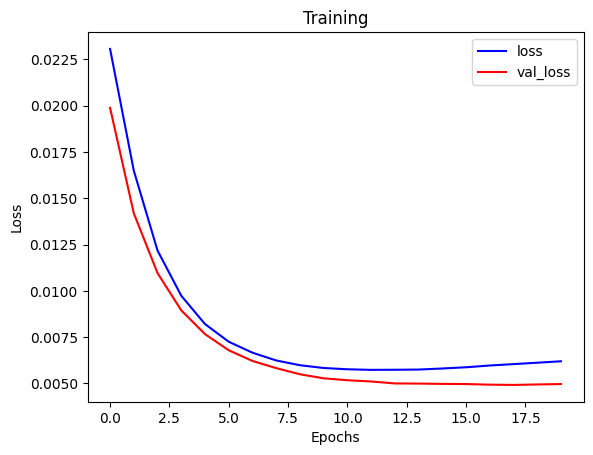

In [ ]:
import matplotlib.pyplot as plt

torch.save(model, "/content/drive/MyDrive/faster_rcnn_batch_32_epochs_20.pth") # save model to file

# plot losses
train_loss = [x.cpu().detach().numpy() for x in train_loss_list]
validation_loss = [x.cpu().detach().numpy() for x in validation_loss_list]

plt.plot(train_loss, "-", color='b', label="loss")
plt.plot(validation_loss, "-", color='r', label="val_loss")
plt.title("Training")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

Ab hier ist Test
[{'boxes': tensor([[592.9861, 670.1681, 649.3581, 746.8841],
        [579.4091, 678.1037, 635.3399, 772.8256],
        [581.8137, 661.9742, 661.9599, 788.5300],
        [ 84.4444,  97.7317,  98.0185, 110.7906],
        [ 84.8519, 101.1567, 100.7724, 115.6268]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.2541, 0.1699, 0.1458, 0.0616, 0.0581], device='cuda:0')}]


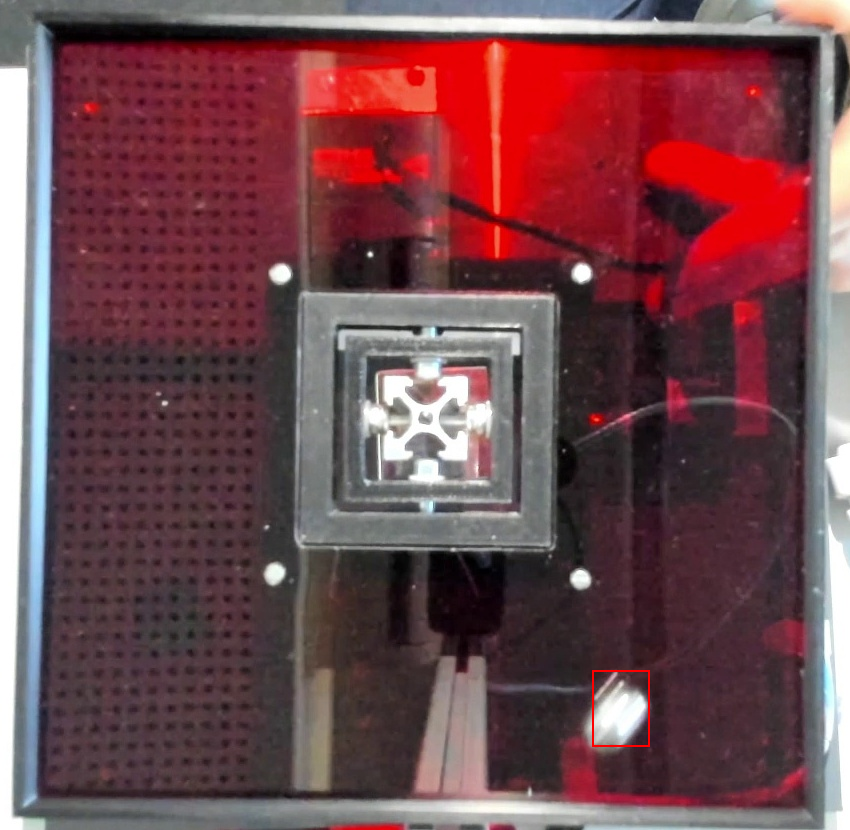

[592.98615, 670.1681, 649.3581, 746.8841]


In [ ]:
model = torch.load("/content/drive/MyDrive/faster_rcnn_batch_32_epochs_20.pth")

def inference(img, device, model):
    #model.eval()
    with torch.no_grad():
        pred = model([img.to(device)]) # forward pass

    # display image with bbox
    transform = T.ToPILImage()
    img = transform(img)
    print(pred)
    x1, y1, x2, y2 = pred[0]["boxes"].cpu().detach().numpy()[0]
    draw = ImageDraw.Draw(img)
    draw.rectangle([x1, y1, x2, y2], fill=None, outline="#ff0000cc", width=2)
    display(img)
    return [x1,y1,x2,y2]

img, _ = validation_dataset[random.randint(0, len(validation_dataset) - 1)]
print('Ab hier ist Test')
model.eval()


pred = inference(img, device, model)
print(pred)